In [2]:
from ocpmodels.preprocessing import AtomsToGraphs
from ocpmodels.datasets import SinglePointLmdbDataset, TrajectoryLmdbDataset, LmdbDataset
import ase.io
from ase.build import bulk
from ase.build import fcc100, add_adsorbate, molecule

import matplotlib.pyplot as plt
import lmdb
import pickle
from tqdm import tqdm
import torch
import os
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
def get_predata (lmdb_path, pre_path):
    dataset= LmdbDataset({"src": lmdb_path})
    energies = torch.tensor([data.y_relaxed for data in dataset])
    sid = torch.tensor([data.sid for data in dataset])
    sorted_index = sorted(range(len(sid)), key=lambda i: sid[i])
    energies=energies[sorted_index]
    
    pre_data = np.load(pre_path)
    pre = pre_data['energy']
    ids = pre_data['ids']
    ids = np.array(list(map(int, ids)))
    sorted_index = sorted(range(len(ids)), key=lambda i: ids[i])
    pre=pre[sorted_index]
    return (energies,pre)

In [4]:
folder_path = '/media/zwbai/DATA/dft/alloy_copy/vasp_cal/'
lmdb_file_train = folder_path + 'CuO2_strain_train.lmdb'
lmdb_file_test = folder_path + 'CuO2_strain_test.lmdb'
pre_train_path = '/home/zwbai/work/ocp-main/ocp/results/2024-03-02-17-33-52/is2re_predictions.npz'
pre_test_path = '/home/zwbai/work/ocp-main/ocp/results/2024-03-02-17-31-44/is2re_predictions.npz'

In [5]:
e_train, pre_train = get_predata(lmdb_file_train, pre_train_path)
e_test, pre_test = get_predata(lmdb_file_test, pre_test_path)

In [6]:
# 将四列数据拼接为一个Pandas DataFrame
df1 = pd.concat([pd.DataFrame(e_train), pd.DataFrame(pre_train)], axis=1)
# 重置列索引（可选）
df1.columns = ['True','Predict']

df2 = pd.concat([pd.DataFrame(e_test), pd.DataFrame(pre_test)], axis=1)
# 重置列索引（可选）
df2.columns = ['True','Predict']


In [7]:
new_column_name = 'Species'
df1[new_column_name] = 'train'
df2[new_column_name] = 'test'
result = pd.concat([df1, df2], axis=0, ignore_index=True)
result

,True,Predict,Species
0,-0.590512,-0.650797,train
1,-0.890392,-0.925234,train
2,0.078234,0.136088,train
3,-0.629698,-0.706763,train
4,-0.624748,-0.651154,train
...,...,...,...
1336,-0.890544,-0.895110,test
1337,-0.857060,-0.901505,test
1338,-0.024980,-0.018427,test
1339,-0.638578,-0.511228,test


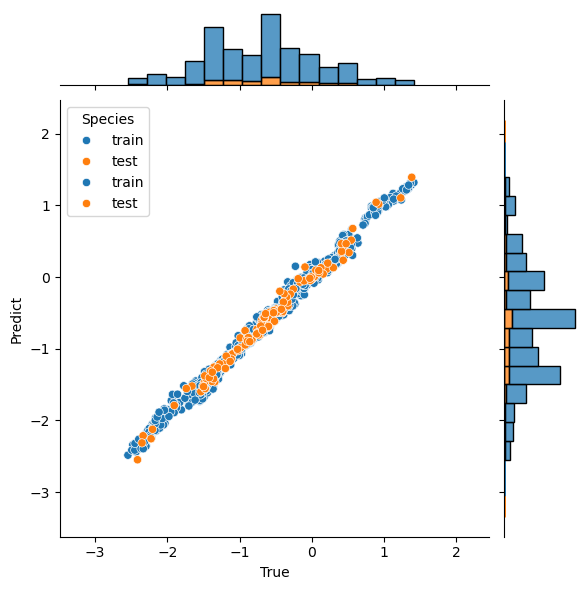

In [8]:
g = sns.jointplot(data=result,x="True", y="Predict", hue="Species")
g.plot_joint(sns.scatterplot)
g.plot_marginals(sns.histplot, **dict(bins=15, multiple="stack"))
plt.show()

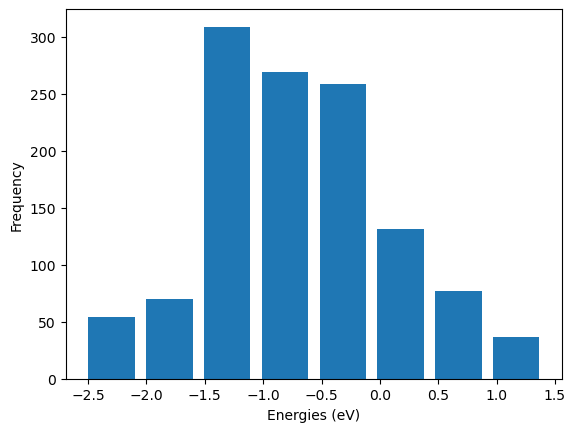

In [9]:
plt.hist(e_train, bins = 8, rwidth=0.8)
# plt.yscale("log")
plt.xlabel("Energies (eV)")
plt.ylabel("Frequency")
plt.show()

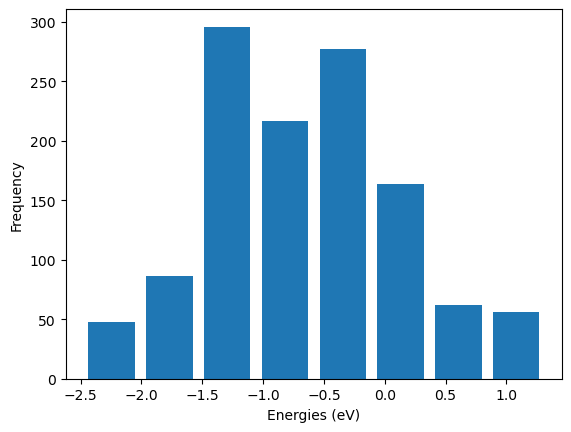

In [10]:
plt.hist(pre_train, bins = 8, rwidth=0.8)
# plt.yscale("log")
plt.xlabel("Energies (eV)")
plt.ylabel("Frequency")
plt.show()

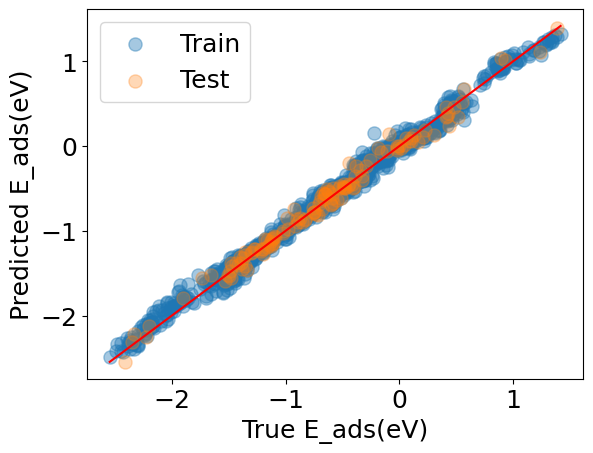

In [11]:
# 画图
plt.rcParams.update({'font.size': 18})

import matplotlib.pyplot as plt
plt.scatter(e_train, pre_train,alpha=0.4, s =90, label='Train') 
plt.scatter(e_test, pre_test,alpha=0.3, s =90, label='Test')

plt.plot([min(e_train),max(e_train)],[min(e_train),max(e_train)], color = 'r' )

plt.xlabel("True E_ads(eV)")
plt.ylabel("Predicted E_ads(eV)")
plt.legend()
plt.show()

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Fixing random state for reproducibility
np.random.seed(19680801)

# some random data
x = np.random.randn(1000)
y = np.random.randn(1000)


def scatter_hist(x, y, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y)

    # now determine nice limits by hand:
    binwidth = 0.25
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth

    bins = np.arange(-lim, lim + binwidth, binwidth)
    ax_histx.hist(x, bins=bins)
    ax_histy.hist(y, bins=bins, orientation='horizontal')

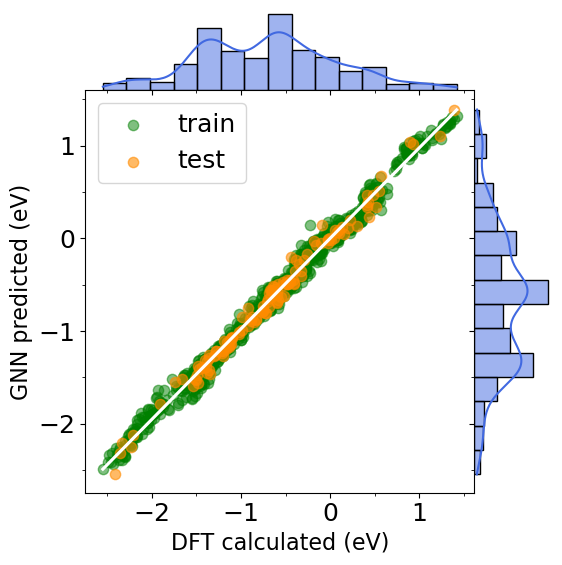

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
# plt.rcParams['font.family'] = 'Arial'
# 使用jointplot绘制联合分布图
plot = sns.jointplot(x='True', y='Predict',
                    data=result,
                    color='w',
                    kind='reg',
                    space=0.0,
                    ratio=5,
                    marginal_kws=dict(bins=15, color='royalblue'))

# 在联合分布图上添加自定义散点
# 注意：这里为df1和df2的散点图层分别指定了不同的标签
plot.ax_joint.scatter(df1['True'], df1['Predict'], alpha=0.5, s=55, label='train', color='g')
plot.ax_joint.scatter(df2['True'], df2['Predict'], alpha=0.6, s=55, label='test', color='darkorange')

# 设置主刻度和副刻度
# 获取x轴和y轴的轴对象
ax_x = plot.ax_marg_x
ax_y = plot.ax_marg_y

# 设置副刻度
# 假设我们想要在主刻度之间添加一个副刻度
# 首先，我们需要获取主刻度的位置
major_locator = ticker.MultipleLocator(1)  # 假设主刻度间隔为1
ax_x.xaxis.set_major_locator(major_locator)
ax_y.yaxis.set_major_locator(major_locator)

# 然后，我们创建一个副刻度定位器，其间隔为主刻度间隔的一半
minor_locator = ticker.MultipleLocator(0.5)  # 副刻度间隔为0.5
ax_x.xaxis.set_minor_locator(minor_locator)
ax_y.yaxis.set_minor_locator(minor_locator)
# 设置主刻度向内

# ax_x.tick_params(axis='x', which='both',  direction='in')
# ax_y.tick_params(axis='y', which='both',  direction='in')

# 添加图例
plot.ax_joint.legend(loc='upper left')
# 设置x和y轴的标签
plot.set_axis_labels('DFT calculated (eV)', 'GNN predicted (eV)', fontsize=16)

# 显示图表
plt.show()

In [14]:
sns.utils.get_data_home()

'/home/zwbai/.cache/seaborn'

/home/zwbai/miniconda3/envs/ocp-models2/lib/python3.9/site-packages/seaborn/axisgrid.py:2219: UserWarning: The marginal plotting function has changed to `histplot`, which does not accept the following argument(s): rug.
  warnings.warn(msg, UserWarning)


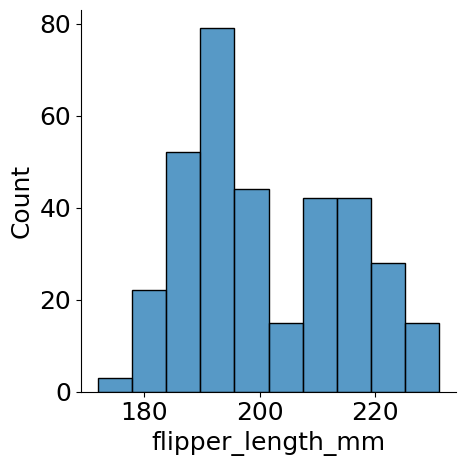

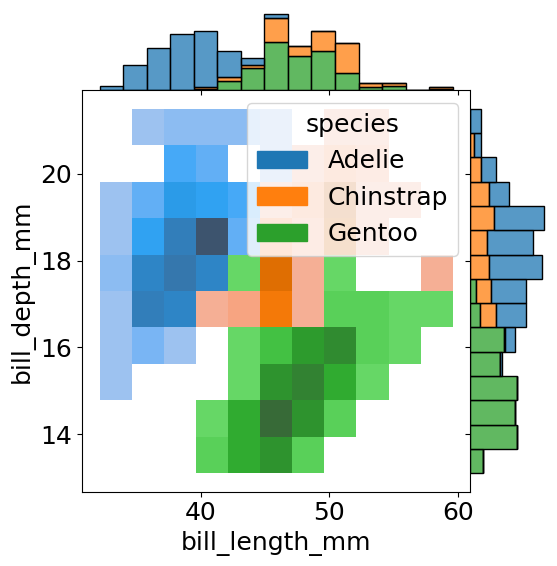

In [15]:
penguins = sns.load_dataset("penguins")
sns.displot(penguins, x="flipper_length_mm")
sns.jointplot(
    data=penguins,
    x="bill_length_mm", y="bill_depth_mm", hue="species",
    space=0.0,
    kind="hist",
    marginal_kws=dict(bins=15, rug=True, multiple="stack")
)

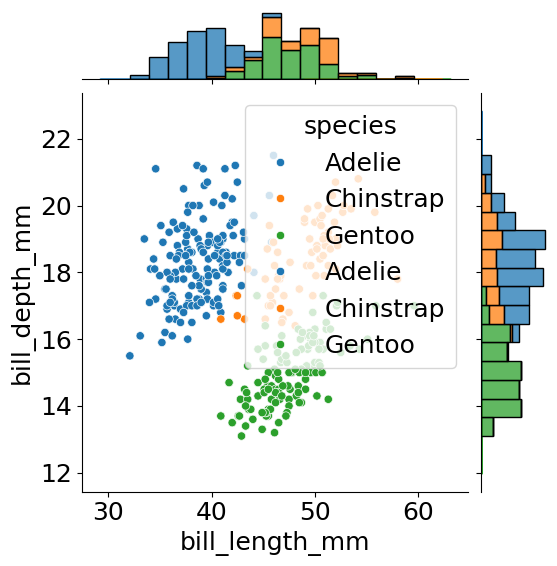

In [16]:
g = sns.jointplot(data=penguins,x="bill_length_mm", y="bill_depth_mm", hue="species")
g.plot_joint(sns.scatterplot)
g.plot_marginals(sns.histplot, **dict(bins=15, multiple="stack"))
plt.show()

In [17]:
import math
from sklearn.metrics import mean_squared_error

# 假设 y_pred 和 y_true 是两个长度相同的数组，分别代表预测值和真实值
# 计算均方根误差
rmse = math.sqrt(mean_squared_error(e_train, pre_train))
print("RMSE:", rmse)

rmse = math.sqrt(mean_squared_error(e_test, pre_test))
print("RMSE:", rmse)


RMSE: 0.07608538999790392
RMSE: 0.0796206829960833


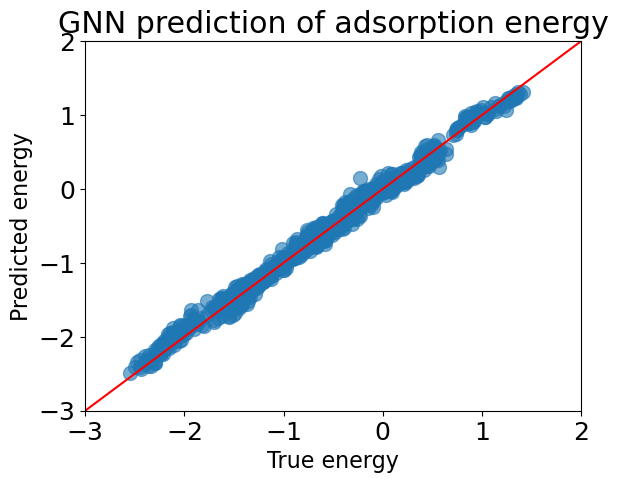

In [18]:
import matplotlib.pyplot as plt
import numpy as np

x = e_train
y = pre_train
fig, ax = plt.subplots()
# 绘制散点图，并设置图形参数
ax.scatter(x, y, alpha=0.6, s =100)
# 计算一三象限角平分线的参数
xx = np.linspace(-4, 4, 2)
yy = xx

plt.plot(yy, yy, c='r')
# 设置x和y轴刻度

# 添加标题、x轴标签、y轴标签和图例
plt.title('GNN prediction of adsorption energy')
plt.xlabel('True energy',fontsize = 16)
plt.ylabel('Predicted energy',fontsize = 16)
# plt.legend(loc='best')
# 设置x和y轴刻度，使其长度相等

# ax.axis('equal')
# 设置x和y轴的范围
plt.xlim(-3, 2)
plt.ylim(-3, 2)
# plt.axis('equal')
# 显示图形
# 这里可以添加你的绘图代码
plt.show()
